## Image CLEF Medical Caption 2019 - Applied Machine Learning
### 4th Assignment
***
> Nikolaos Fragkomanolis AM:8160142 <br />
> Athens University of Economics and Business 20/01/2020 <br /> 


* At first, we import the necessary libs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import cv2
import csv
import glob
import re
import time
import os
import copy

from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data exploration
* We read the *'.csv'* files that contain the concepts for the training set, the validation-set and the name of each label.
* We fetch the first 5 images with their tag IDs and their respective names to get an idea of the images.
* We calculate the frequency of each tag ID.
* We find how many labels there are per image on average.

* In total, there are 5528 unique tags.

In [73]:
concepts = pd.read_csv('string_concepts.csv', names=["Concepts"], header=None)
temp = concepts["Concepts"].str.split('\t', n=1, expand=True)
concepts['tag'] = temp[0]
concepts['name'] = temp[1]
concepts.drop(columns=["Concepts"], inplace=True)
print(len(concepts))
concepts.head()

5528


,tag,name
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...


* Fetch the first 5 images of training-set and reshape.

In [3]:
train_images = []
files = glob.glob("./training-set/training-set/*.jpg")
i=0
for img in files:
    full_size_image = cv2.imread(img)
    train_images.append(cv2.resize(full_size_image, (128,128), interpolation=cv2.INTER_CUBIC))
    i += 1
    if (i == 5):
        break

In [4]:
print(len(train_images), train_images[0].shape)

5 (128, 128, 3)


* Read the labels for each image in training set.
* We add a suffix *.jpg* in the end of each filename in order to have the true name of each image.

In [5]:
train_labels = pd.read_csv('train_concepts.csv').sort_values(by=['image']).reset_index(drop=True)
train_labels['image'] = train_labels['image'] + '.jpg'
print(len(train_labels))
train_labels.head()

56629


,image,tags
0,ROCO_CLEF_00000.jpg,C0027442
1,ROCO_CLEF_00001.jpg,C0741302
2,ROCO_CLEF_00003.jpg,C0040399;C0741302;C2936859;C0796095;C0751438;C...
3,ROCO_CLEF_00004.jpg,C0687028;C0005388;C1261287;C1550227
4,ROCO_CLEF_00005.jpg,C0772294;C0231881;C0221198;C0441633


* Join the name of the first 5 images' tags as a column in a `sample` dataframe to plot the images.
* Using the regex `^C\d+|C\B\d+` we search in the relative column, a sequence of a string starting with the letter *C*, whether it is in the beginning of the whole string or not, followed by digits.

In [6]:
sample = pd.DataFrame(train_labels[:5])
sample['name'] = sample['tags'].str.replace("^C\d+|C\B\d+", 
                                        lambda x: concepts.loc[concepts["tag"]==str(x.group(0)), 'name'].iloc[0])
sample

,image,tags,name
0,ROCO_CLEF_00000.jpg,C0027442,pars nasalis pharyngis
1,ROCO_CLEF_00001.jpg,C0741302,atypia
2,ROCO_CLEF_00003.jpg,C0040399;C0741302;C2936859;C0796095;C0751438;C...,single photon emission tomography;atypia;nsx;t...
3,ROCO_CLEF_00004.jpg,C0687028;C0005388;C1261287;C1550227,a tube shaped organ structure;portion of bile;...
4,ROCO_CLEF_00005.jpg,C0772294;C0231881;C0221198;C0441633,alesion;resonance;visible lesion;diagnostic sc...


* Plot the first 5 images.
* Replacing the character `;` with `\n` we achieve not printing each label of an image on another's image labels.
* Each row of the title corresponds with the label of the same row under the image.

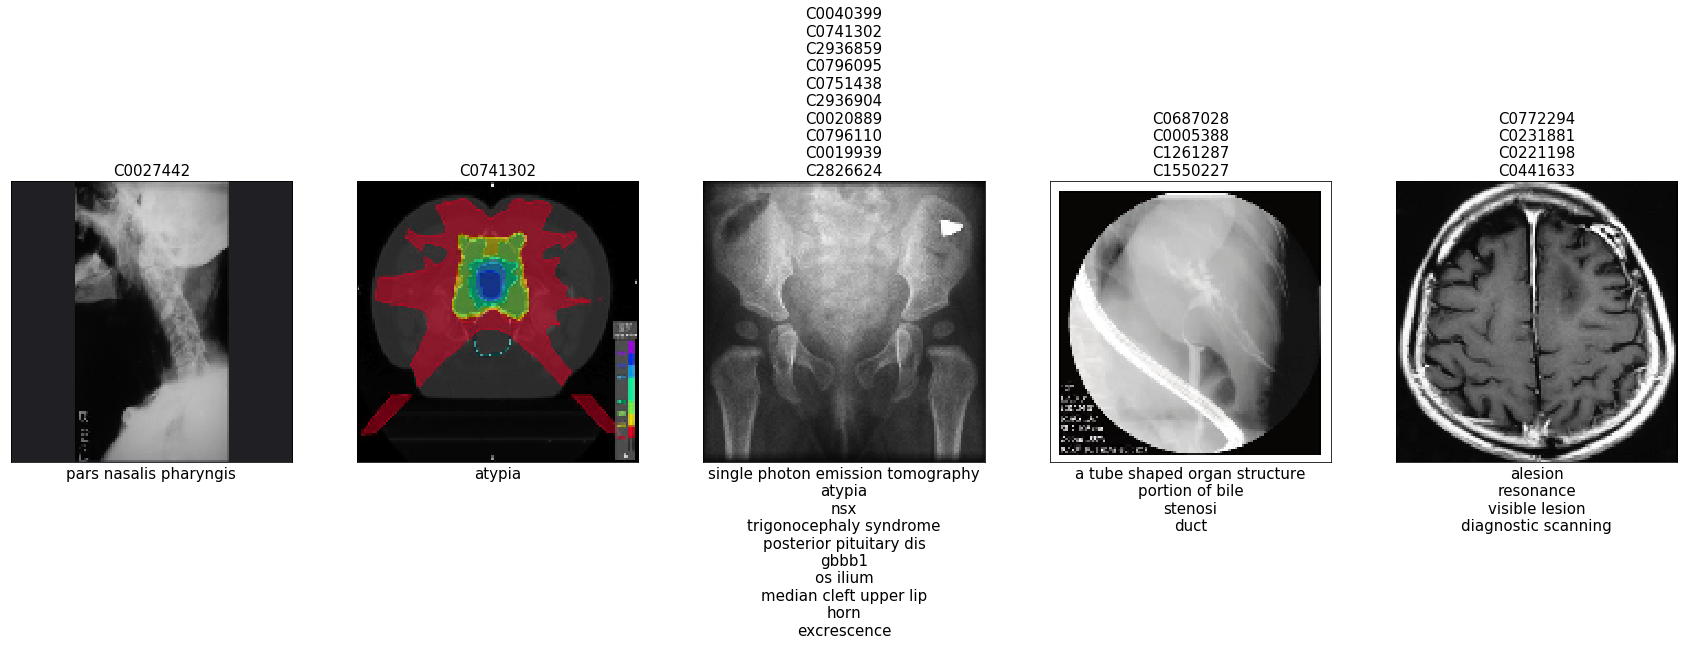

In [7]:
plt.figure(figsize=(30,30))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)    
    plt.xlabel(sample.loc[i, 'name'].replace(';', '\n'), size=15)
    plt.title(train_labels.loc[i, 'tags'].replace(';', '\n'), size=15)

* Read the filenames and the relative tags for the validation images.
* We perform a `.split()` method in order to generate our data and their tags correctly, later during the training of the CNN.

In [8]:
val_labels = pd.read_csv('val_concepts.csv').sort_values(by=['image']).reset_index(drop=True)
val_labels['image'] = val_labels['image'] + '.jpg'
val_labels['tags'] = val_labels['tags'].str.split(";")
print(len(val_labels))
val_labels.head()

14157


,image,tags
0,ROCO_CLEF_00002.jpg,"[C0751437, C0224434, C0022742, C0224439, C1553..."
1,ROCO_CLEF_00006.jpg,"[C0226964, C0935624, C0018827, C0006901, C0018..."
2,ROCO_CLEF_00010.jpg,"[C0040399, C0221198, C0772294, C0935598, C0027..."
3,ROCO_CLEF_00012.jpg,"[C0022742, C0012725, C0035139, C0224498, C0524..."
4,ROCO_CLEF_00016.jpg,"[C1962945, C1548003, C0026367, C0043299, C1550..."


* Frequency of each label.
* Function `chainer` helps us "*explode*" the images' tags in order to have a single row for each tag's presence.
* We can see the tags of the first two images expanded in multiple rows.

In [9]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))

train_labels_freq = pd.DataFrame(train_labels['tags'])
lens = train_labels_freq['tags'].str.split(';').map(len)
expl = pd.DataFrame({'tags': chainer(train_labels_freq['tags'])})
print(len(expl))
expl.head(6)

345826


,tags
0,C0027442
1,C0741302
2,C0040399
3,C0741302
4,C2936859
5,C0796095


* We perform a single `value_counts()` method to count the frequency of each tag.
* As the paper states, there are 312 concepts which are not used. For this reason the length of the dataframe that contains the frequences is 5216.
* The first 6 tags that are more frequent are shown below, which are the same with the paper's results.

In [10]:
freq = pd.DataFrame({'images': expl['tags'].value_counts()})
#freq['images'] = ((freq['images']/sum(freq['images']))*100).round(2)
print(len(freq), sum(freq['images']), min(freq['images']))
freq.join(concepts.set_index('tag')).head(6)

5216 345826 1


,images,name
C0441633,6733,diagnostic scanning
C0043299,6321,x-ray procedure
C1962945,6318,radiogr
C0040395,6235,tomogr
C0034579,6127,pantomogr
C0817096,5981,thoracics


* Tags per image.
* We create a new column in `train_labels` dataframe which indicates the number of tags the image has.
* And, we find the *average* of this column.

In [11]:
tpr = train_labels[['image', 'tags']]
tpr['tags_per_image'] = tpr['tags'].str.count(';') + 1
tpr.head()

,image,tags,tags_per_image
0,ROCO_CLEF_00000.jpg,C0027442,1
1,ROCO_CLEF_00001.jpg,C0741302,1
2,ROCO_CLEF_00003.jpg,C0040399;C0741302;C2936859;C0796095;C0751438;C...,10
3,ROCO_CLEF_00004.jpg,C0687028;C0005388;C1261287;C1550227,4
4,ROCO_CLEF_00005.jpg,C0772294;C0231881;C0221198;C0441633,4


In [12]:
print(np.mean(tpr['tags_per_image']))

6.106871037807484


So, there are **6 concepts per image** on average.

### Baseline Classifier
* Here, we implement a `Dummy Classifier` on our training data set, sampling from the labels based on their frequency.

In [97]:
t_labels = train_labels['tags']
bin_labels = []
for t in list(t_labels):
    print(t)
    pivot = []
    for i in range(0,5528):
        pivot.append(0)
    for l in t:
        print(l)
        #break
        pivot[concepts.loc[str(l), 'tag'].index] += 1
        break
    bin_labels.append(pivot)
    break

bin_labels     

['C0027442']
C0027442


KeyError: 'C0027442'

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_classes = mlb.fit_transform(train_labels['tags'])
train_classes.shape

(56629, 5216)

In [68]:
val_classes = mlb.fit_transform(val_labels['tags'])
val_classes.shape

(14157, 3233)

In [13]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(train_labels['image'], train_labels['tags'])

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [14]:
dummy_clf.predict()

TypeError: predict() missing 1 required positional argument: 'X'

### Convolutional Neural Network
* Here, we build our convolutional neural networks.
* The are models which were succesfully trained.
* But, there are models which were not loaded in the notebook, probably due to resources issues.
* We also calculate the `f1-score` using the evaluation code of ImageCLEF.

* Defining the path where the images are stored.

In [13]:
PATH = os.path.abspath(os.getcwd())
train_dir = os.path.join(PATH, 'training-set')
validation_dir = os.path.join(PATH, 'validation-set')
print('Path of training set:', train_dir)
print('Path of validation set:', validation_dir)

Path of training set: C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\training-set
Path of validation set: C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\validation-set


#### CNN in class
* Getting a simple convolutional neural network, which was presented in class.

In [15]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

* We split the tags of the training labels in order to pass it into the generator.

In [13]:
train_labels['tags'] = train_labels['tags'].str.split(';')
train_labels.head()

,image,tags
0,ROCO_CLEF_00000.jpg,[C0027442]
1,ROCO_CLEF_00001.jpg,[C0741302]
2,ROCO_CLEF_00003.jpg,"[C0040399, C0741302, C2936859, C0796095, C0751..."
3,ROCO_CLEF_00004.jpg,"[C0687028, C0005388, C1261287, C1550227]"
4,ROCO_CLEF_00005.jpg,"[C0772294, C0231881, C0221198, C0441633]"


* Generator for training images.
* Using the `flow_from_dataframe` method, we can pass the true labels through a dataframe we already have. We also specify the path to which the training images are stored.
* Parameter `classes` requires a list with the classes (tags, or concepts), so we convert the column `tag` of dataframe `concepts` to a list.

In [18]:
train_data_gen = train_image_generator.flow_from_dataframe(directory='./training-set/training-set/',
                                                           dataframe=train_labels,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=concepts['tag'].values.tolist())

Found 56629 validated image filenames belonging to 5528 classes.


* Generator for validation images.

In [19]:
val_data_gen = validation_image_generator.flow_from_dataframe(directory='./validation-set/validation-set/',
                                                              dataframe=val_labels,
                                                              x_col='image',
                                                              y_col='tags',
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=concepts['tag'].values.tolist())

Found 14157 validated image filenames belonging to 5528 classes.


* Building the model and defining the layers.

In [21]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5528, activation='sigmoid')
])

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

* Summary of the model we built.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

The CNN starts to get trained.

In [25]:
total_train = 56629
total_val = 14157

In [120]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
442/442 [==============================] - 1265s 3s/step - loss: 0.0214 - accuracy: 0.9967 - val_loss: 0.0164 - val_accuracy: 0.9989
Epoch 2/15
442/442 [==============================] - 1296s 3s/step - loss: 0.0140 - accuracy: 0.9989 - val_loss: 0.0063 - val_accuracy: 0.9989
Epoch 3/15
442/442 [==============================] - 1324s 3s/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.0060 - val_accuracy: 0.9989
Epoch 4/15
442/442 [==============================] - 1343s 3s/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0058 - val_accuracy: 0.9989
Epoch 5/15
442/442 [==============================] - 1330s 3s/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy: 0.9989
Epoch 6/15
442/442 [==============================] - 1308s 3s/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy: 0.9989
Epoch 7/15
442/442 [==============================] - 1289s 3s/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0057 - val_accuracy:

* Saving the model in order to use it later without training it again.

In [121]:
model.save('imageCLEF_1.h5')

In [21]:
model = load_model('imageCLEF_1.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20736)            

#### F1 Score
* Here, we use the evaluation code of ImageCLEF in order to calculate the f1-score.

* We need to get the predictions we did from our model.

In [22]:
predictions = model.predict(val_data_gen, verbose = 1)

111/111 [==============================] - 101s 914ms/step


* For each image, we want to keep only the tags that had a probability over 16% (Percentage used in the paper).

*Note: There is a typo. I wanted to write 16 instead of 60 as a name for the list I create here.*

In [57]:
predictions_over60 = []
for prediction in predictions:
    pos = []
    for perc in prediction:
        if (perc > 0.16):
            pos.append([prediction.tolist().index(perc), perc])
    predictions_over60.append(pos)

* The length of the list with the elements we kept is 14157, same with the validation images' number.
* Also, the list we created `predictions_over60` is a list of lists where each list contains the index in order to find the corresponding tag later and the probability.

In [103]:
print(len(predictions_over60))
predictions_over60[0:2]

14157


[[[978, 0.21024197],
  [1075, 0.3361239],
  [2780, 0.17753628],
  [4431, 0.27832812],
  [4840, 0.34866315]],
 [[116, 0.79760283],
  [454, 0.3806551],
  [756, 0.6149182],
  [820, 0.663611],
  [985, 0.19360971],
  [988, 0.16856292],
  [1036, 0.34151208],
  [1850, 0.2641533],
  [2019, 0.21301264],
  [2225, 0.18910122],
  [2473, 0.54017794],
  [2784, 0.20588067],
  [3084, 0.26307625],
  [3485, 0.18002334],
  [3628, 0.25708824]]]

* We have 1101 images for which we did not get any probability.

In [78]:
i = 0
for res in predictions_over60:
    if not res:
        i+=1
print(i)

1101


* It is time to remove them and convert the indexes to their related tags using `concepts` DataFrame. 
* For this reason we create a simple function to convert the `predictions_over60` to a list of objects, where each object is a list containing the predicted tag(s) for each image.
* After executing and calling the method we can see the tags we predicted for the two first validation images.

In [125]:
def possibilities_toTags(predictions, validation_labels, concepts):
    
    predicted_labels = []
    temp_predictions = copy.deepcopy(predictions)
    
    for idx, val in enumerate(temp_predictions):
        if not val:
            validation_labels.drop(idx, inplace=True)
            predictions.remove(temp_predictions[idx])
        else:
            tags = []
            for conc in val:
                tags.append(concepts.loc[conc[0], 'tag'])
            predicted_labels.append(tags)
    
    return predicted_labels, validation_labels

val_predicted_labels = val_labels.copy()
predictions_toConvert = copy.deepcopy(predictions_over60)
predicted_labels, val_predicted_labels = possibilities_toTags(predictions_toConvert,
                                                              val_predicted_labels,
                                                              concepts)
print(len(predicted_labels), len(val_predicted_labels))
predicted_labels[0:2]

13056 13056


[['C0750430', 'C0796494', 'C1963894', 'C0456171', 'C1321013'],
 ['C1552853',
  'C0027442',
  'C0226773',
  'C4025651',
  'C0184913',
  'C1548806',
  'C0052136',
  'C0019066',
  'C0280793',
  'C0191840',
  'C1831808',
  'C0031845',
  'C0278024',
  'C1302808',
  'C4329495']]

* Let's check if the function works correctly and we got the correct results.
* As we can see, the tag which is in the 116th row (see results of `predictions_over60`) of `concepts` dataframe - also, the first predicted tag for the second image - is *C1552853*.

In [122]:
concepts.loc[116, 'tag']

'C1552853'

* DataFrame `val_predicted_labels` contains the truth labels for each validation image. The only difference with the original csv `val_concepts` is that `val_predicted_labels` contains the images for which we had probabilities over 16%.

In [123]:
val_predicted_labels

,image,tags
0,ROCO_CLEF_00002.jpg,"[C0751437, C0224434, C0022742, C0224439, C1553..."
1,ROCO_CLEF_00006.jpg,"[C0226964, C0935624, C0018827, C0006901, C0018..."
2,ROCO_CLEF_00010.jpg,"[C0040399, C0221198, C0772294, C0935598, C0027..."
3,ROCO_CLEF_00012.jpg,"[C0022742, C0012725, C0035139, C0224498, C0524..."
4,ROCO_CLEF_00016.jpg,"[C1962945, C1548003, C0026367, C0043299, C1550..."
5,ROCO_CLEF_00018.jpg,"[C1705199, C0000726, C0009924, C0441633, C0449..."
6,ROCO_CLEF_00020.jpg,"[C0042149, C0005767, C0175676, C1561540, C0005..."
7,ROCO_CLEF_00023.jpg,"[C0040395, C0042449, C0034579, C0817096, C0024..."
8,ROCO_CLEF_00025.jpg,"[C0933845, C0037993]"
9,ROCO_CLEF_00036.jpg,[C1185729]


* We convert the column `tags` to the original csv file's format.

In [126]:
s = ';'
l = val_predicted_labels['tags']
joinned = []
for el in l:
    temp = s.join(el)
    joinned.append(temp)

val_predicted_labels['tags'] = joinned
val_predicted_labels.head()

,image,tags
0,ROCO_CLEF_00002.jpg,C0751437;C0224434;C0022742;C0224439;C1553386;C...
1,ROCO_CLEF_00006.jpg,C0226964;C0935624;C0018827;C0006901;C0018670;C...
2,ROCO_CLEF_00010.jpg,C0040399;C0221198;C0772294;C0935598;C0027809;C...
3,ROCO_CLEF_00012.jpg,C0022742;C0012725;C0035139;C0224498;C0524414;C...
4,ROCO_CLEF_00016.jpg,C1962945;C1548003;C0026367;C0043299;C1550227


* We export the csv file.

In [138]:
export_csv = val_predicted_labels.to_csv (r'C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\imageCLEF_1\ground_truth_labels.csv', 
                        index = None, header=False, quoting=csv.QUOTE_NONE, sep='\t')

* Same for the labels we predicted. 

In [129]:
candidate_predictions = pd.DataFrame(val_predicted_labels['image'])
candidate_predictions['predicted'] = predicted_labels

s = ';'
l = candidate_predictions['predicted']
joinned = []

for el in l:
    temp = s.join(el)
    joinned.append(temp)

candidate_predictions['predicted'] = joinned
candidate_predictions

,image,predicted
0,ROCO_CLEF_00002.jpg,C0750430;C0796494;C1963894;C0456171;C1321013
1,ROCO_CLEF_00006.jpg,C1552853;C0027442;C0226773;C4025651;C0184913;C...
2,ROCO_CLEF_00010.jpg,C0825429;C0449878;C0184913;C1548806;C0031845;C...
3,ROCO_CLEF_00012.jpg,C0412513;C0019066;C0031845;C4329495;C0982327
4,ROCO_CLEF_00016.jpg,C0796494;C0456171;C1321013;C1550722
5,ROCO_CLEF_00018.jpg,C4084784
6,ROCO_CLEF_00020.jpg,C0152344;C0185188;C0237607
7,ROCO_CLEF_00023.jpg,C0449878;C0184913;C1548806;C0031845
8,ROCO_CLEF_00025.jpg,C0449878
9,ROCO_CLEF_00036.jpg,C0796494;C0456171;C1321013;C1550722


* Export the csv file.

In [139]:
export_csv = candidate_predictions.to_csv (r'C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\imageCLEF_1\predicted_labels.csv', 
                        index = None, header=False, quoting=csv.QUOTE_NONE, sep='\t')

* Running the evaluation, we get the following score.

In [ ]:
%load evaluate-f1.py

In [140]:
%run evaluate-f1.py .\imageCLEF_1\predicted_labels.csv .\imageCLEF_1\ground_truth_labels.csv

Input parameters
********************************
Candidate file is ".\imageCLEF_1\predicted_labels.csv"
Ground Truth file is ".\imageCLEF_1\ground_truth_labels.csv"
Processing concept sets...
********************************
1000 / 13056  concept sets processed...
2000 / 13056  concept sets processed...
3000 / 13056  concept sets processed...
4000 / 13056  concept sets processed...
5000 / 13056  concept sets processed...
6000 / 13056  concept sets processed...
7000 / 13056  concept sets processed...
8000 / 13056  concept sets processed...
9000 / 13056  concept sets processed...
10000 / 13056  concept sets processed...
11000 / 13056  concept sets processed...
12000 / 13056  concept sets processed...
13000 / 13056  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 957
2 : 1278
3 : 1490
4 : 1557
5 : 1509
6 : 1264
7 : 1135
8 : 875
9 : 734
10 : 585
11 : 414
12 : 315
13 : 253
14 : 194
15 : 115
16 : 129
17 : 59
18 : 45
19 : 34
2

#### CNN with Dropout
* We follow almost the same procedure with the previous CNN with two differences:
    * We change the image height and width to 224 and
    * We add a Dropout layer after evey MaxPooling layer while building the model.

In [14]:
batch_size = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [15]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [16]:
train_data_gen = train_image_generator.flow_from_dataframe(directory='./training-set/training-set/',
                                                           dataframe=train_labels,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=concepts['tag'].values.tolist())

val_data_gen = validation_image_generator.flow_from_dataframe(directory='./validation-set/validation-set/',
                                                              dataframe=val_labels,
                                                              x_col='image',
                                                              y_col='tags',
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=concepts['tag'].values.tolist())

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [17]:
drop_model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5528, activation='sigmoid')
])

In [18]:
drop_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [19]:
drop_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        1

In [20]:
total_train = 56629
total_val = 14157

In [21]:
epochs = 2
history = drop_model.fit_generator(
            train_data_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=total_val // batch_size
)

Epoch 1/2
442/442 [==============================] - 2877s 7s/step - loss: 0.0211 - accuracy: 0.9969 - val_loss: 0.0193 - val_accuracy: 0.9987
Epoch 2/2
442/442 [==============================] - 2866s 6s/step - loss: 0.0192 - accuracy: 0.9988 - val_loss: 0.0193 - val_accuracy: 0.9987


In [22]:
drop_model.save('imageCLEF_2.h5')

#### F1 Score
* We follow again the same procedure to calculate the score we achieved.

In [29]:
d_predictions = drop_model.predict(val_data_gen, verbose = 1)

111/111 [==============================] - 155s 1s/step


In [30]:
d_predictions_over16 = []
for prediction in d_predictions:
    pos = []
    for perc in prediction:
        if (perc > 0.16):
            pos.append([prediction.tolist().index(perc), perc])
    d_predictions_over16.append(pos)

In [32]:
print(len(d_predictions_over16))
d_predictions_over16[0:2]

14157


[[[1075, 0.16876459],
  [1850, 0.20122665],
  [2122, 0.17910564],
  [3674, 0.19124478],
  [4431, 0.17114416],
  [4840, 0.24840152]],
 [[44, 0.22635934],
  [70, 0.25576463],
  [96, 0.22124434],
  [628, 0.24780509],
  [1075, 0.20057201],
  [2263, 0.2230309],
  [3040, 0.16924039],
  [3069, 0.2262488],
  [3674, 0.19444767],
  [4200, 0.19782528],
  [4431, 0.20491841],
  [4449, 0.191041],
  [4840, 0.2406803],
  [5360, 0.19267204],
  [5478, 0.16634941]]]

* There are 609 images for which we did not get any probability. We need to remove them again.

In [33]:
i = 0
for res in d_predictions_over16:
    if not res:
        i+=1
print(i)

609


* We use the `possibilities_toTags` function again, to convert the indexes to their respective tags.

In [36]:
d_val_predicted_labels = val_labels.copy()
d_predictions_toConvert = copy.deepcopy(d_predictions_over16)
d_predicted_labels, d_val_predicted_labels = possibilities_toTags(d_predictions_toConvert,
                                                                d_val_predicted_labels,
                                                                concepts)
print(len(d_predicted_labels), len(d_val_predicted_labels))
d_predicted_labels[0:2]

13548 13548


[['C0796494', 'C0019066', 'C0264956', 'C0441513', 'C0456171', 'C1321013'],
 ['C2828105',
  'C0043037',
  'C1365522',
  'C0020676',
  'C0796494',
  'C0223792',
  'C0448362',
  'C1547580',
  'C0441513',
  'C1835820',
  'C0456171',
  'C0014099',
  'C1321013',
  'C0411943',
  'C0230463']]

* As far as we can see from the length of the dataframe that contains the truth labels for each validation image, we succesfully deduced the length of `val_labels`. Now, `d_val_predicted_labels` contains the true tags for the images we got some possibility percentage.

In [37]:
print(len(d_val_predicted_labels))
d_val_predicted_labels.head()

13548


,image,tags
0,ROCO_CLEF_00002.jpg,"[C0751437, C0224434, C0022742, C0224439, C1553..."
1,ROCO_CLEF_00006.jpg,"[C0226964, C0935624, C0018827, C0006901, C0018..."
2,ROCO_CLEF_00010.jpg,"[C0040399, C0221198, C0772294, C0935598, C0027..."
3,ROCO_CLEF_00012.jpg,"[C0022742, C0012725, C0035139, C0224498, C0524..."
4,ROCO_CLEF_00016.jpg,"[C1962945, C1548003, C0026367, C0043299, C1550..."


* We change again the format of column `tags` in order not to run into conflicts with the evaluation code.

In [38]:
s = ';'
l = d_val_predicted_labels['tags']
joinned = []
for el in l:
    temp = s.join(el)
    joinned.append(temp)

d_val_predicted_labels['tags'] = joinned
d_val_predicted_labels.head()

,image,tags
0,ROCO_CLEF_00002.jpg,C0751437;C0224434;C0022742;C0224439;C1553386;C...
1,ROCO_CLEF_00006.jpg,C0226964;C0935624;C0018827;C0006901;C0018670;C...
2,ROCO_CLEF_00010.jpg,C0040399;C0221198;C0772294;C0935598;C0027809;C...
3,ROCO_CLEF_00012.jpg,C0022742;C0012725;C0035139;C0224498;C0524414;C...
4,ROCO_CLEF_00016.jpg,C1962945;C1548003;C0026367;C0043299;C1550227


In [43]:
export_csv = d_val_predicted_labels.to_csv (r'C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\imageCLEF_2\ground_truth_labels.csv', 
                        index = None, header=False, quoting=csv.QUOTE_NONE, sep='\t')

* Same process for the labels we predicted for each image.

In [46]:
d_candidate_predictions = pd.DataFrame(d_val_predicted_labels['image'])
d_candidate_predictions['predicted'] = d_predicted_labels

s = ';'
l = d_candidate_predictions['predicted']
joinned = []

for el in l:
    temp = s.join(el)
    joinned.append(temp)

d_candidate_predictions['predicted'] = joinned
print(len(d_candidate_predictions))
d_candidate_predictions.head()

13548


,image,predicted
0,ROCO_CLEF_00002.jpg,C0796494;C0019066;C0264956;C0441513;C0456171;C...
1,ROCO_CLEF_00006.jpg,C2828105;C0043037;C1365522;C0020676;C0796494;C...
2,ROCO_CLEF_00010.jpg,C1548806;C0019066;C0264956
3,ROCO_CLEF_00012.jpg,C0825429;C0449878;C0184913;C1548806;C0019066;C...
4,ROCO_CLEF_00016.jpg,C1517569;C3889399


In [47]:
export_csv = d_candidate_predictions.to_csv (r'C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\imageCLEF_2\predicted_labels.csv', 
                        index = None, header=False, quoting=csv.QUOTE_NONE, sep='\t')

* And, here is the score we achieved after adding an extra *Dropout* layer after each *MaxPooling* layer in our CNN.

In [48]:
%run evaluate-f1.py .\imageCLEF_2\predicted_labels.csv .\imageCLEF_2\ground_truth_labels.csv

Input parameters
********************************
Candidate file is ".\imageCLEF_2\predicted_labels.csv"
Ground Truth file is ".\imageCLEF_2\ground_truth_labels.csv"
Processing concept sets...
********************************
1000 / 13548  concept sets processed...
2000 / 13548  concept sets processed...
3000 / 13548  concept sets processed...
4000 / 13548  concept sets processed...
5000 / 13548  concept sets processed...
6000 / 13548  concept sets processed...
7000 / 13548  concept sets processed...
8000 / 13548  concept sets processed...
9000 / 13548  concept sets processed...
10000 / 13548  concept sets processed...
11000 / 13548  concept sets processed...
12000 / 13548  concept sets processed...
13000 / 13548  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 987
2 : 1326
3 : 1549
4 : 1608
5 : 1551
6 : 1313
7 : 1192
8 : 918
9 : 757
10 : 603
11 : 435
12 : 325
13 : 263
14 : 197
15 : 131
16 : 131
17 : 62
18 : 48
19 : 31
2

#### MobileNetV2
* Pretrained model which was presented in class, too.
* It was finally not implemented due to considerable resources needed. Did not really understand the reason!
* But, my attemp is the following.

In [49]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

batch_size=32


train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [50]:
train_data_gen = train_image_generator.flow_from_dataframe(directory='./training-set/training-set/',
                                                           dataframe=train_labels,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=concepts['tag'].values.tolist())

val_data_gen = validation_image_generator.flow_from_dataframe(directory='./validation-set/validation-set/',
                                                              dataframe=val_labels,
                                                              x_col='image',
                                                              y_col='tags',
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=concepts['tag'].values.tolist())

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [51]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

from tensorflow.keras import layers

import tensorflow_hub as hub

FEATURE_EXTRACTOR_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [52]:
feature_extraction_layer = hub.KerasLayer(FEATURE_EXTRACTOR_URL,
                                          trainable=False,
                                          input_shape=(IMG_WIDTH, IMG_HEIGHT,3))

* We add the classification layer which is a `Dense` layer with 5528 neurons as output, as the number of classes we have.

In [53]:
prediction_layer = Dense(5528, activation='sigmoid')

* We build the model.

In [54]:
MobileNetV2_model = tf.keras.Sequential([
                            feature_extraction_layer,
                            prediction_layer
                    ])

MobileNetV2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5528)              7081368   
Total params: 9,339,352
Trainable params: 7,081,368
Non-trainable params: 2,257,984
_________________________________________________________________


In [55]:
base_learning_rate = 0.0001
MobileNetV2_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

* Unfortunately the process was (maybe) too heavy for the PC (my PC) used to train this model and everything was freezed after executing the following command. Thus, spending 10 minutes in front of a freezed screen to see some results, the browser closed entirely, interrupting the model's training.

In [56]:
epochs = 2

history = MobileNetV2_model.fit(
            train_data_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=total_val // batch_size
)

KeyboardInterrupt: 

#### 2nd Attempt for MobileNetV2
* It was finally not implemented due to considerable resources needed. Did not really understand the reason!
* But, my attemp is the following.

In [28]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

batch_size=32


train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [29]:
train_data_gen = train_image_generator.flow_from_dataframe(directory='./training-set/training-set/',
                                                           dataframe=train_labels,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=concepts['tag'].values.tolist())

val_data_gen = validation_image_generator.flow_from_dataframe(directory='./validation-set/validation-set/',
                                                              dataframe=val_labels,
                                                              x_col='image',
                                                              y_col='tags',
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=concepts['tag'].values.tolist())

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [30]:
MNet = keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

14540800/14536120 [==============================] - 24s 2us/step


In [31]:
prediction_layer = Dense(5528, activation='sigmoid')

In [32]:
MNet_model_2 = tf.keras.Sequential([
                            MNet,
                            prediction_layer
                    ])

MNet_model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 5528)              5533528   
Total params: 9,072,512
Trainable params: 9,038,400
Non-trainable params: 34,112
_________________________________________________________________


In [33]:
base_learning_rate = 0.0001
MNet_model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

* The model was interrupted again, so I did not achieve fitting.

In [ ]:
total_train = 56629
total_val = 14157
epochs = 2

history = MNet_model_2.fit(
                train_data_gen,
                steps_per_epoch=total_train // batch_size,
                epochs=epochs,
                validation_data=val_data_gen,
                validation_steps=total_val // batch_size
)

#### DenseNet
* It was finally not implemented due to considerable resources needed. Did not really understand the reason!
* But, my attemp is the following.

In [41]:
dense = keras.applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [42]:
prediction_layer = keras.layers.Dense(5528, activation='sigmoid')

In [43]:
dense_model = Sequential([
    dense,
    prediction_layer
])

In [44]:
dense_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1000)              8062504   
_________________________________________________________________
dense_2 (Dense)              (None, 5528)              5533528   
Total params: 13,596,032
Trainable params: 13,512,384
Non-trainable params: 83,648
_________________________________________________________________


* Kernel died here ! So, I did not achieve fitting the model again.

In [ ]:
history = dense_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5


#### ResNet_v2_50
* It was finally not implemented due to considerable resources needed. Did not really understand the reason!
* But, my attemp is the following.

In [26]:
batch_size=128
IMG_HEIGHT = 224
IMG_WIDTH = 224


train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [27]:
train_data_gen = train_image_generator.flow_from_dataframe(directory='./training-set/training-set/',
                                                           dataframe=train_labels,
                                                           x_col='image',
                                                           y_col='tags',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=concepts['tag'].values.tolist())

val_data_gen = validation_image_generator.flow_from_dataframe(directory='./validation-set/validation-set/',
                                                              dataframe=val_labels,
                                                              x_col='image',
                                                              y_col='tags',
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=concepts['tag'].values.tolist())

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [28]:
from tensorflow.keras import layers

import tensorflow_hub as hub

MOBILENETV1_URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4" 

In [29]:
MobileNetV1_layer = hub.KerasLayer(MOBILENETV1_URL,
                                          trainable=False,
                                          input_shape=(IMG_WIDTH, IMG_HEIGHT,3))

In [30]:
prediction_layer = Dense(5528, activation='sigmoid')

In [31]:
MobileNetV1_model = tf.keras.Sequential([
                            MobileNetV1_layer,
                            prediction_layer
                    ])

MobileNetV1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              4254889   
_________________________________________________________________
dense_1 (Dense)              (None, 5528)              5539056   
Total params: 9,793,945
Trainable params: 5,539,056
Non-trainable params: 4,254,889
_________________________________________________________________


In [32]:
base_learning_rate = 0.0001
MobileNetV1_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

Attempt with no success, again! Memory was not enough.

In [ ]:
epochs = 2
total_train = 56629
total_val = 14157

history = MobileNetV1_model.fit(
            train_data_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=total_val // batch_size
)

#### Create file for test images
* Before starting the following procedure, I tried predicting using the model which achieved the highest score (0.0035), but I got weird results, like only 1.
* So, because of lack of time I continue with the results that the first model gave me (The one presented in class).

In [37]:
batch_size = 1
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

PATH = os.path.abspath(os.getcwd())
test_dir = os.path.join(PATH, 'test-set')
print(test_dir)

test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=test_dir,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\test-set
Found 10000 images belonging to 1 classes.


In [38]:
test_model = load_model('imageCLEF_1.h5')
test_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20736)            

In [39]:
test_predictions = test_model.predict(test_data_gen, verbose = 1)

10000/10000 [==============================] - 285s 29ms/step


In [41]:
test_predictions_over16 = []
for prediction in test_predictions:
    pos = []
    for perc in prediction:
        if (perc > 0.16):
            pos.append([prediction.tolist().index(perc), perc])
    test_predictions_over16.append(pos)

In [42]:
len(test_predictions_over16)

10000

* There are 751 images for which we did not get any prediction.

In [43]:
i = 0
for res in test_predictions_over16:
    if not res:
        i+=1
print(i)

751


* But, we do not remove them this time due to submission rules.

In [44]:
test_predictions_over16

[[[139, 0.18166667],
  [616, 0.5469695],
  [899, 0.18901],
  [1075, 0.6006489],
  [2709, 0.1967178],
  [4431, 0.6225163],
  [4840, 0.6423628],
  [4857, 0.16879791]],
 [[174, 0.5499637], [685, 0.7506479], [3882, 0.7129133]],
 [[347, 0.74631953],
  [1024, 0.9365125],
  [1442, 0.73454106],
  [1784, 0.69004583],
  [2668, 0.41131583],
  [5060, 0.1624892]],
 [[1075, 0.3133509], [4431, 0.327256], [4840, 0.3211956]],
 [[1075, 0.39835224], [4431, 0.40583563], [4840, 0.37682492]],
 [[607, 0.20137915],
  [1075, 0.34140146],
  [3674, 0.7986536],
  [4431, 0.23452887],
  [4840, 0.29400647]],
 [[2784, 0.23876673]],
 [[3069, 0.26882493], [3247, 0.2241709], [4737, 0.19834939]],
 [],
 [[685, 0.2487723],
  [913, 0.64473766],
  [2122, 0.16258454],
  [3069, 0.7461326],
  [3247, 0.31642467],
  [3882, 0.7699394],
  [4737, 0.5412378]],
 [[323, 0.23115396],
  [347, 0.29089767],
  [780, 0.22644043],
  [1024, 0.56011885],
  [2668, 0.689046],
  [3352, 0.27497238],
  [3386, 0.24983561],
  [4212, 0.31115958],
  [43

* We convert the indexes of labels to their tag names.

In [47]:
test_predicted_labels = []
for img in test_predictions_over16:
    if not img:
        test_predicted_labels.append([])
    else:
        tags = []
        for pos in img:
            tags.append(concepts.loc[pos[0], 'tag'])
        test_predicted_labels.append(tags)

print(len(test_predicted_labels))
test_predicted_labels[0:2]        

10000


[['C1857618',
  'C0021670',
  'C0036537',
  'C0796494',
  'C3897431',
  'C0456171',
  'C1321013',
  'C1550722'],
 ['C1450294', 'C2753459', 'C0450042']]

* We bring the dataframe we are ready to export, to the format needed according to the competition rules.

In [56]:
test = pd.DataFrame(test_data_gen.filenames, columns=['images'])
test['images'] = test['images'].str[9:-4]

s = ';'
l = test_predicted_labels
joinned = []
for el in l:
    temp = s.join(el)
    joinned.append(temp)

test['test_predictions'] = joinned
test

,images,test_predictions
0,ROCO_CLEF_TEST_00001,C1857618;C0021670;C0036537;C0796494;C3897431;C...
1,ROCO_CLEF_TEST_00002,C1450294;C2753459;C0450042
2,ROCO_CLEF_TEST_00003,C0205950;C0152344;C0393009;C0184934;C0185188;C...
3,ROCO_CLEF_TEST_00004,C0796494;C0456171;C1321013
4,ROCO_CLEF_TEST_00005,C0796494;C0456171;C1321013
5,ROCO_CLEF_TEST_00006,C1947907;C0796494;C0441513;C0456171;C1321013
6,ROCO_CLEF_TEST_00007,C0031845
7,ROCO_CLEF_TEST_00008,C1547580;C0001632;C0007776
8,ROCO_CLEF_TEST_00009,
9,ROCO_CLEF_TEST_00010,C2753459;C1546599;C0264956;C1547580;C0001632;C...


* Export the csv with the predictions for the test set.

In [58]:
export_csv = test.to_csv (r'C:\Users\nicko\Desktop\ML 4th Assignment\imageclef\test_predictions.csv', 
                        index = None, header=False, quoting=csv.QUOTE_NONE, sep='\t')